In [1]:
!wget -O ISBI2016_ISIC_Part1_Training_Data.zip "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip"
!unzip ISBI2016_ISIC_Part1_Training_Data.zip

!wget -O ISBI2016_ISIC_Part1_Training_GroundTruth.zip "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip"
!unzip ISBI2016_ISIC_Part1_Training_GroundTruth.zip


--2024-11-19 03:50:43--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.97.140, 16.182.72.33, 52.216.32.209, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.97.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 631625308 (602M) [application/zip]
Saving to: ‘ISBI2016_ISIC_Part1_Training_Data.zip’

ISBI2016_ISIC_Part1 100%[===================>] 602.36M  48.9MB/s    in 13s     

2024-11-19 03:50:57 (45.4 MB/s) - ‘ISBI2016_ISIC_Part1_Training_Data.zip’ saved [631625308/631625308]

Archive:  ISBI2016_ISIC_Part1_Training_Data.zip
 extracting: ISBI2016_ISIC_Part1_Training_Data/ISIC_0000000.jpg  
 extracting: ISBI2016_ISIC_Part1_Training_Data/ISIC_0000001.jpg  
 extracting: ISBI2016_ISIC_Part1_Training_Data/ISIC_0000002.jpg  
 extracting: ISBI2016_ISIC_Part1_Training_Data/ISIC_000

In [2]:
!pip install segmentation-models-pytorch
!pip install torchinfo

#Import libraries
import torch
import segmentation_models_pytorch as smp
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Image manipulation
from PIL import Image

# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.auto import tqdm

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=ddf9d83ebbc25a56da8b50b097a8dc4d87ed6bcb6d0dad88cd9b4a8868baaa45
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=cfdf9d87c71f67e1f29b54eb064a225a47ac562ba36960f33904d86b96a2c467
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# utils

## evaluation

In [ ]:
def compute_accuracy_loss(model, data_loader, criterion, device="cuda"):
    accuracy = 0
    loss = 0
    with torch.no_grad():

        for i, (image, mask) in enumerate(data_loader):

            image = image.float().to(device)
            mask = mask.float().to(device)

            mask_pred = model(image)

            loss_batch = criterion(mask_pred,mask)
            loss += loss_batch.item()

            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask.int(),
                                             threshold=0.5,
                                             mode='binary')
            accuracy_batch = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()
            accuracy += accuracy_batch
    return accuracy / len(data_loader), loss / len(data_loader)
    


def compute_accuracy(model, data_loader, device="cuda"):
    accuracy = 0
    with torch.no_grad():

        for i, (image, mask) in enumerate(data_loader):

            image = image.float().to(device)
            mask = mask.to(device)

            mask_pred = model(image)
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask,
                                             threshold=0.5,
                                             mode='binary')
            accuracy_batch = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()

            accuracy += accuracy_batch
    return accuracy / len(data_loader)
    
    
def compute_loss(model, data_loader, criterion, device="cuda"):

    loss = 0
    with torch.no_grad():
        for i, (image, mask) in enumerate(data_loader):
            image = image.float().to(device)
            mask = mask.float().to(device)

            mask_pred = model(image)
            loss_batch = criterion(mask_pred,mask)

            loss += loss_batch.item()

    return loss / len(data_loader)


## metrics

In [ ]:
def check_metrics(dataloader, model, device="cuda"):
    accuracy_list = []
    jaccard_list = []
    dice_list = []
    pix_acc_list = []
    specificity_list = []
    sensitivity_list = []

    with torch.no_grad():
        for image, mask in dataloader:
            image = image.to(device).type(torch.float32)
            mask = mask.to(device)
            pred = model(image)
            pred = (pred > 0.5).int()

            tp, fp, fn, tn = smp.metrics.get_stats(pred, mask,
                                             threshold=0.5,
                                             mode='binary')
            intersection = torch.logical_and(pred, mask).sum().detach()
            union = torch.logical_or(pred, mask).sum().detach()

            sensitivity = smp.metrics.functional.sensitivity(tp, fp, fn, tn, reduction="micro")
            specificity = smp.metrics.functional.specificity(tp, fp, fn, tn, reduction="micro")
            sensitivity_list.append(sensitivity)
            specificity_list.append(specificity)


            accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
            accuracy_list.append(accuracy)

            jaccard_score = intersection / union
            jaccard_list.append(jaccard_score)

            dice_score = (2.0 * intersection) / (pred.sum().detach() + mask.sum().detach())
            dice_list.append(dice_score)
            

    sensitivity = torch.mean(torch.stack(sensitivity_list)).item()
    specificity = torch.mean(torch.stack(specificity_list)).item()
    print(f"Sensitivity: {sensitivity:.6f}")
    print(f"Specificity: {specificity:.6f}")

    pix_acc = torch.mean(torch.stack(accuracy_list)).item()
    print(f"Pixel Accuracy: {pix_acc:.6f}")

    jaccard = torch.mean(torch.stack(jaccard_list)).item()
    print(f"Jaccard Score: {jaccard:.6f}")

    dice = torch.mean(torch.stack(dice_list)).item()
    print(f"Dice Score: {dice:.6f}")

    return sensitivity, specificity, pix_acc, jaccard, dice


## train utils

In [ ]:
import time
import torch
from tqdm.auto import tqdm
from helper_evaluation import compute_accuracy_loss


def train_model(model, num_epochs, train_loader, valid_loader, criterion,
                optimizer, device, scheduler=None, scheduler_on='valid_loss'): # valid_loss or train_loss

    train_loss_list, valid_loss_list, valid_acc_list = [], [],  []

    for epoch in tqdm(range(num_epochs)):

        batch_loss_list = []
        model.train()
        for batch_idx, (image, mask) in enumerate(tqdm(train_loader)):


            image = image.float().to(device)
            mask = mask.float().to(device)

            # ## FORWARD AND BACK PROP
            mask_pred = model(image)
            loss = criterion(mask_pred,mask)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            batch_loss_list.append(loss.item())

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_loss =  sum(batch_loss_list) / len(batch_loss_list)
            valid_acc, valid_loss = compute_accuracy_loss(model, valid_loader, criterion, device=device)
            print(f'Epoch: {epoch+1:02d}/{num_epochs:02d} '
                  f'| Train Loss: {train_loss :.4f} '
                  f'| Validation Loss: {valid_loss :.4f} '
                  f'| Validation Accuracy: {valid_acc*100 :.1f}%')
            train_loss_list.append(train_loss)
            valid_loss_list.append(valid_loss)
            valid_acc_list.append(valid_acc)

        if scheduler is not None:

            if scheduler_on == 'valid_loss':
                scheduler.step(valid_loss_list[-1])
            elif scheduler_on == 'train_loss':
                scheduler.step(train_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')

    return train_loss_list, valid_loss_list, valid_acc_list


## plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random


def plot_loss_accuracy(train_loss_list, val_loss_list, val_acc_list):

    num_epochs = len(train_loss_list)
    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(np.arange(1, num_epochs+1), train_loss_list, color="green", label='Train Loss')
    ax1.plot(np.arange(1, num_epochs+1), val_loss_list, color="red", label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.legend()

    ax2.plot(np.arange(1, num_epochs+1), val_acc_list, color="blue", label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()
    

def plot_img_mask_pred(dataset, index=None, plot_pred=False, model=None, device = "cuda"):
    if not index:
        index = random.randint(0, len(dataset) - 1)

    image = dataset[index][0].permute(1,2,0)
    mask = dataset[index][1].permute(1,2,0)

    if plot_pred:
        img_to_pred = dataset[index][0].unsqueeze(0).type(torch.float32).to(device)
        pred = model(img_to_pred)
        pred = pred.squeeze(0).cpu().detach().permute(1,2,0)
        pred[pred < 0]=0
        pred[pred > 0]=1


        # Plot the image
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Image")

        # Plot the mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")

        # Plot the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap='gray')
        plt.title("Prediction")

        # Show the plots
        plt.tight_layout()
        plt.show()

    else:
        # Plot the image
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Image")

        # Plot the mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")

        # Show the plots
        plt.tight_layout()
        plt.show()



In [4]:

# settings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate =5e-4
batch_size = 16
size =(128,128)

In [5]:
device

device(type='cuda')

In [6]:
# Combine the base directory with subdirectories
image_dir = "/content/ISBI2016_ISIC_Part1_Training_Data"
gt_dir = "/content/ISBI2016_ISIC_Part1_Training_GroundTruth"

# Get paths to the training and target images
image_paths = sorted([os.path.join(image_dir, fname)
                      for fname in os.listdir(image_dir)
                      if fname.endswith(".jpg")])
gt_paths = sorted([os.path.join(gt_dir, fname)
                    for fname in os.listdir(gt_dir)
                    if fname.endswith(".png")])

# Check if dimensions are equal
print("Number of samples in the image folder:", len(image_paths))
print("Number of samples in the mask folder:", len(gt_paths))

Number of samples in the image folder: 900
Number of samples in the mask folder: 900


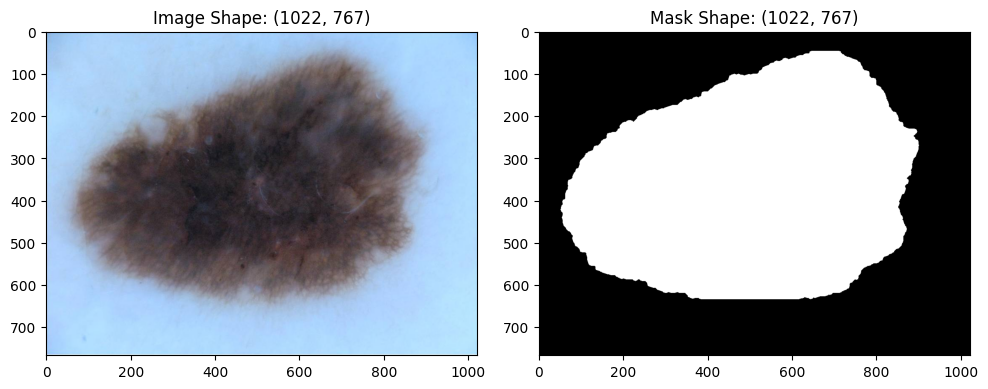

In [7]:
# Define the paths to your image and segmentation mask
image_path = image_paths[0]
mask_path = gt_paths[0]

# Open the image and mask using Pillow
image = Image.open(image_path)
mask = Image.open(mask_path)

# Get the dimensions (shape) of the image and mask
image_shape = image.size  # Returns (width, height)
mask_shape = mask.size    # Returns (width, height)

# Convert the image and mask to NumPy arrays for visualization
image_array = plt.imread(image_path)
mask_array = plt.imread(mask_path)

# Plot the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_array)
plt.title(f"Image Shape: {image_shape}")

# Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_array, cmap='gray')  # Assuming the mask is grayscale
plt.title(f"Mask Shape: {mask_shape}")

# Show the plots
plt.tight_layout()
plt.show()

In [8]:
percentage_test = 0.05
percentage_validation = 0.1

# Set your random seed for reproducibility
random_seed = 142

# Split your data into training, validation, and test sets
image_paths_trainval, image_paths_test, mask_paths_trainval, mask_paths_test = train_test_split(image_paths, gt_paths, test_size=percentage_test, random_state=random_seed)
image_paths_train, image_paths_val, mask_paths_train, mask_paths_val = train_test_split(image_paths_trainval, mask_paths_trainval, test_size=percentage_validation, random_state=random_seed)


In [9]:
class LesionSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        mask_name = self.mask_paths[idx]

        img = Image.open(img_name)
        mask = Image.open(mask_name)

        img = np.array(img)
        mask = np.array(mask)
        mask[mask==255.0] = 1.0

        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask,0)
        return img,mask

In [10]:
train_transform = A.Compose([A.Resize(size[0],size[1]),
                             A.Rotate(limit=15,p=0.1),
                             A.HorizontalFlip(p=0.5),
                             A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(size[0],size[1]),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

In [11]:
train_dataset =  LesionSegmentationDataset(image_paths_train, mask_paths_train, transform = train_transform)
val_dataset = LesionSegmentationDataset(image_paths_val, mask_paths_val, transform = val_transform)
test_dataset = LesionSegmentationDataset(image_paths_test, mask_paths_test, transform = val_transform)

train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=False)

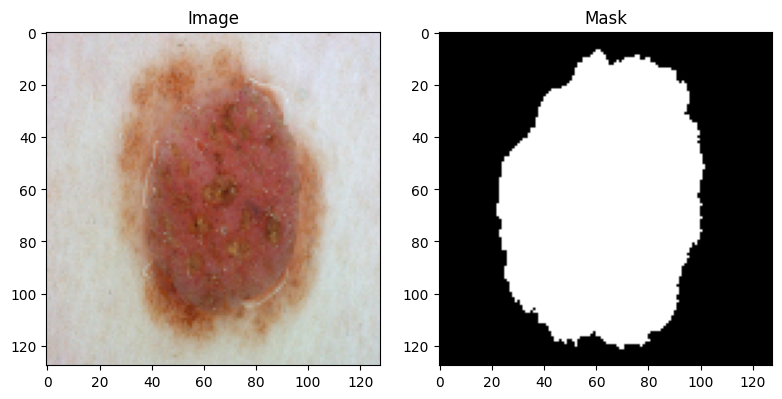

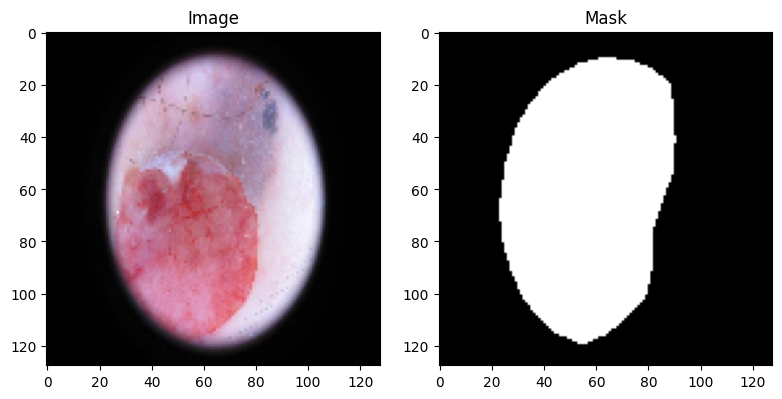

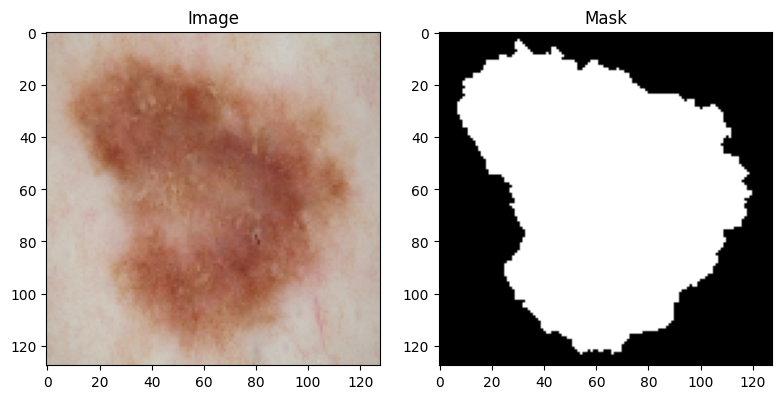

In [12]:
plot_img_mask_pred(train_dataset)

plot_img_mask_pred(val_dataset)

plot_img_mask_pred(test_dataset)



In [13]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3,stride=1,padding=1)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3,stride=1,padding=1)

    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x)))).to(device)

class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs  = chs
        self.upconvs  = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x  = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1):
        super().__init__()
        self.encoder = Encoder(enc_chs)
        self.decoder  = Decoder(dec_chs)
        self.head  = nn.Conv2d(dec_chs[-1], num_class, 1)


    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out = self.head(out)
        return out

In [14]:
model = UNet(enc_chs=(3,32, 64,128,256), dec_chs=(256, 128, 64, 32), num_class=1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=learning_rate/epochs)
#optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()
#criterion = SoftBCEWithLogitsLoss()
#criterion = JaccardLoss()

scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min', verbose=True)

model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [15]:
summary(model, input_size=(batch_size,3, size[0],size[1]))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [16, 1, 128, 128]         --
├─Encoder: 1-1                           [16, 32, 128, 128]        --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-1                   [16, 32, 128, 128]        10,144
│    └─MaxPool2d: 2-2                    [16, 32, 64, 64]          --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-2                   [16, 64, 64, 64]          55,424
│    └─MaxPool2d: 2-4                    [16, 64, 32, 32]          --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-3                   [16, 128, 32, 32]         221,440
│    └─MaxPool2d: 2-6                    [16, 128, 16, 16]         --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-4              

In [19]:
epochs = 50

In [20]:
train_loss_lst, valid_loss_lst, valid_acc_lst = train_model(model, epochs, train_dataloader, val_dataloader,
                                criterion, optimizer,device, scheduler=scheduler, scheduler_on='train_loss')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 01/50 | Train Loss: 0.3036 | Validation Loss: 0.3261 | Validation Accuracy: 87.4%


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 02/50 | Train Loss: 0.3175 | Validation Loss: 0.2915 | Validation Accuracy: 89.7%


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 03/50 | Train Loss: 0.3237 | Validation Loss: 0.4544 | Validation Accuracy: 84.9%


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 04/50 | Train Loss: 0.3241 | Validation Loss: 0.3001 | Validation Accuracy: 87.9%


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 05/50 | Train Loss: 0.3169 | Validation Loss: 0.2791 | Validation Accuracy: 90.0%


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 06/50 | Train Loss: 0.3202 | Validation Loss: 0.3380 | Validation Accuracy: 86.1%


  0%|          | 0/49 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plot_loss_accuracy(train_loss_lst, valid_loss_lst, valid_acc_lst)

In [ ]:
model.eval()